<a href="https://colab.research.google.com/github/bedhinesh/capstone-aiml/blob/main/Capstone_Group1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#Import Libraries
# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

# Initialize the random number generator
import random
random.seed(0)

#Tensor Flow
import tensorflow
tensorflow.__version__

#Matplot
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
%matplotlib inline

#Importing drive
from google.colab import drive
#OS
import os
#Numpy
import numpy as np
#Pandas
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from wordcloud import WordCloud

#CV2
import cv2

#Image data Generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import imgaug as ia
from imgaug import augmenters as iaa

In [2]:
#Mount Drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/kaggle"
project_path = '/content/drive/My Drive/kaggle/'
%cd /content/gdrive/My Drive/kaggle

/content/gdrive/My Drive/kaggle


In [38]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file


    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

def load_image(path):
    img = cv2.imread(path, 1)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img[...,::-1]

def extract_file_path(data):
  dataEnriched = pd.DataFrame(data)
  dataEnriched[1]=dataEnriched[0].apply(lambda x: x.image_path().rsplit("/",1)[0])
  dataEnriched[2]=dataEnriched[0].apply(lambda x: x.image_path().rsplit("/",1)[1])
  return dataEnriched

def prepare_annotation_data(data,labels,metaData):
  data[6]=labels[data[5]-1]
  data[7]=data[6].apply(lambda x: x.rsplit(" ",2)[0])
  data[8]=data[6].apply(lambda x: x.rsplit(" ",2)[1])
  data[9]=data[6].apply(lambda x: x.rsplit(" ",2)[2])
  data[10]=data[6].apply(lambda x: x.rsplit(" ",-1)[0])
  pathData = []
  for i in data[0]:
    pathData.append((metaData.loc[metaData[2] == i][0].values)[0])
  data[11] = pathData
  return data

def draw_count_plot(data,column):
  sns.set_style('whitegrid')
  a4_dims = (30, 10)
  fig, ax = plt.subplots(figsize=a4_dims)
  sns.countplot(ax=ax,x=column,data=data, palette='YlGnBu_r',order=data[column].value_counts().index)
  plt.xticks(rotation = 90)
  plt.show()
def draw_word_cloud(data):
  cloudText = ' '.join(data)
  wordcloud = WordCloud().generate(cloudText)
  a4_dims = (30, 10)
  fig, ax = plt.subplots(figsize=a4_dims)
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

def draw_image_from_each_class(data,labels,metaData):
  plt.figure(figsize = (20, 30))
  i=0
  for label in labels:
    plt.subplot(25, 8, i+1)
    i=i+1
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    imageIndex = (data.loc[data[6] == label[0]]).head(1).index.values.astype(int)[0]
    plt.imshow(load_image(metaData[imageIndex].image_path()))
    plt.xlabel(label[0])
  plt.show()
  


In [5]:
# metadata = load_metadata('images')
trainMetaData = load_metadata('car_data/car_data/train/')
print(trainMetaData.shape)
testMetaData = load_metadata('car_data/car_data/test/')
print(testMetaData.shape)
trainMetaDataEnriched=extract_file_path(trainMetaData)
print(trainMetaDataEnriched.shape)
testMetaDataEnriched=extract_file_path(testMetaData)
print(testMetaDataEnriched.shape)

(8144,)
(8041,)
(8144, 3)
(8041, 3)


In [8]:
print(trainMetaDataEnriched.head())
print(testMetaDataEnriched.head())

                                                   0  \
0  car_data/car_data/train/AM General Hummer SUV ...   
1  car_data/car_data/train/AM General Hummer SUV ...   
2  car_data/car_data/train/AM General Hummer SUV ...   
3  car_data/car_data/train/AM General Hummer SUV ...   
4  car_data/car_data/train/AM General Hummer SUV ...   

                                                   1          2  
0  car_data/car_data/train/AM General Hummer SUV ...  07279.jpg  
1  car_data/car_data/train/AM General Hummer SUV ...  06174.jpg  
2  car_data/car_data/train/AM General Hummer SUV ...  02311.jpg  
3  car_data/car_data/train/AM General Hummer SUV ...  01918.jpg  
4  car_data/car_data/train/AM General Hummer SUV ...  00522.jpg  
                                                   0  \
0  car_data/car_data/test/AM General Hummer SUV 2...   
1  car_data/car_data/test/AM General Hummer SUV 2...   
2  car_data/car_data/test/AM General Hummer SUV 2...   
3  car_data/car_data/test/AM General Hummer

In [9]:
annotation_train_csv = pd.read_csv('anno_train.csv', header = None)
annotation_test_csv = pd.read_csv('anno_test.csv', header = None)
data_labels = np.array(pd.read_csv('names.csv',header = None))
train_data = annotation_train_csv.copy()
test_data = annotation_test_csv.copy()

In [13]:
train_data = prepare_annotation_data(train_data,data_labels,trainMetaDataEnriched)
test_data = prepare_annotation_data(test_data,data_labels,testMetaDataEnriched)
print(train_data.shape)
print(test_data.shape)
print(train_data.head())
print(test_data.head())

(8144, 12)
(8041, 12)
          0    1    2     3     4    5                                    6   \
0  00001.jpg   39  116   569   375   14                  Audi TTS Coupe 2012   
1  00002.jpg   36  116   868   587    3                  Acura TL Sedan 2012   
2  00003.jpg   85  109   601   381   91           Dodge Dakota Club Cab 2007   
3  00004.jpg  621  393  1484  1096  134     Hyundai Sonata Hybrid Sedan 2012   
4  00005.jpg   14   36   133    99  106  Ford F-450 Super Duty Crew Cab 2012   

                           7      8     9        10  \
0                    Audi TTS  Coupe  2012     Audi   
1                    Acura TL  Sedan  2012    Acura   
2           Dodge Dakota Club    Cab  2007    Dodge   
3       Hyundai Sonata Hybrid  Sedan  2012  Hyundai   
4  Ford F-450 Super Duty Crew    Cab  2012     Ford   

                                                  11  
0  car_data/car_data/train/Audi TTS Coupe 2012/00...  
1  car_data/car_data/train/Acura TL Sedan 2012/00...  
2

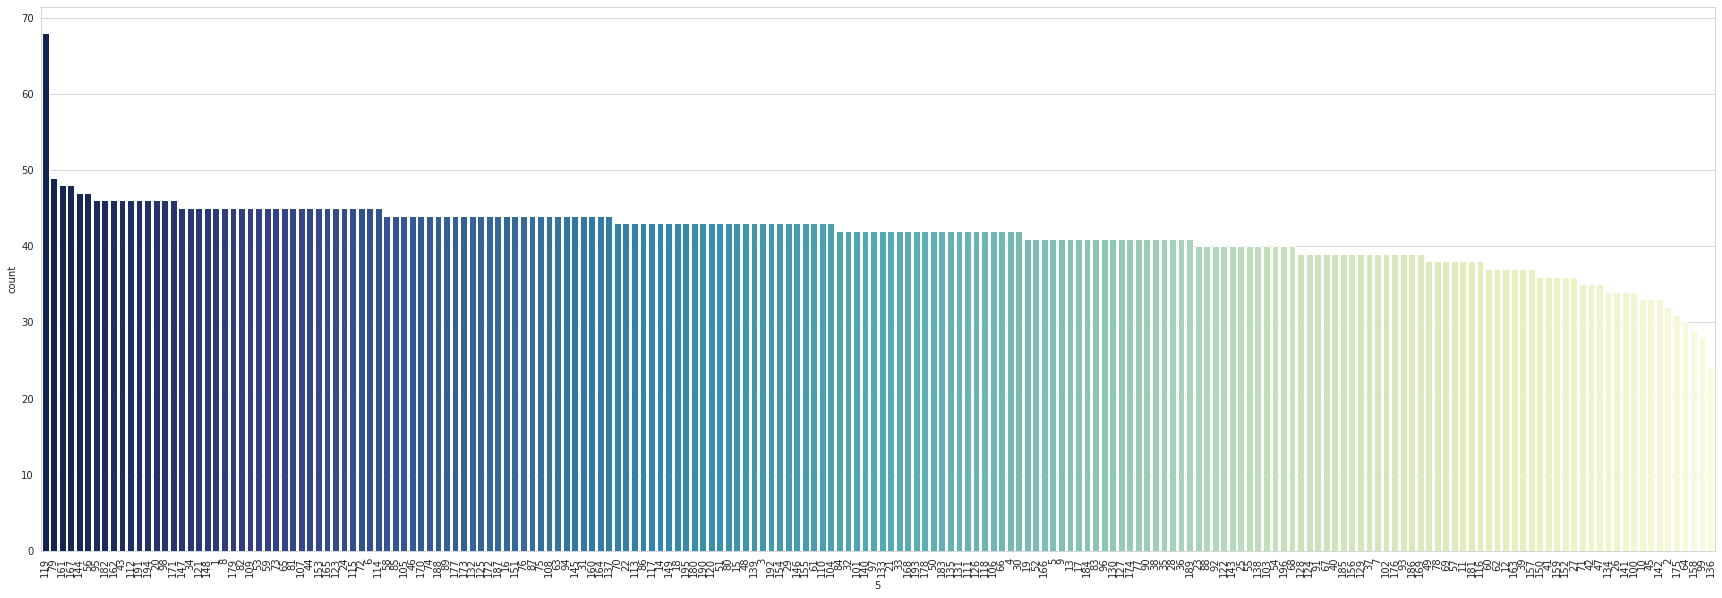

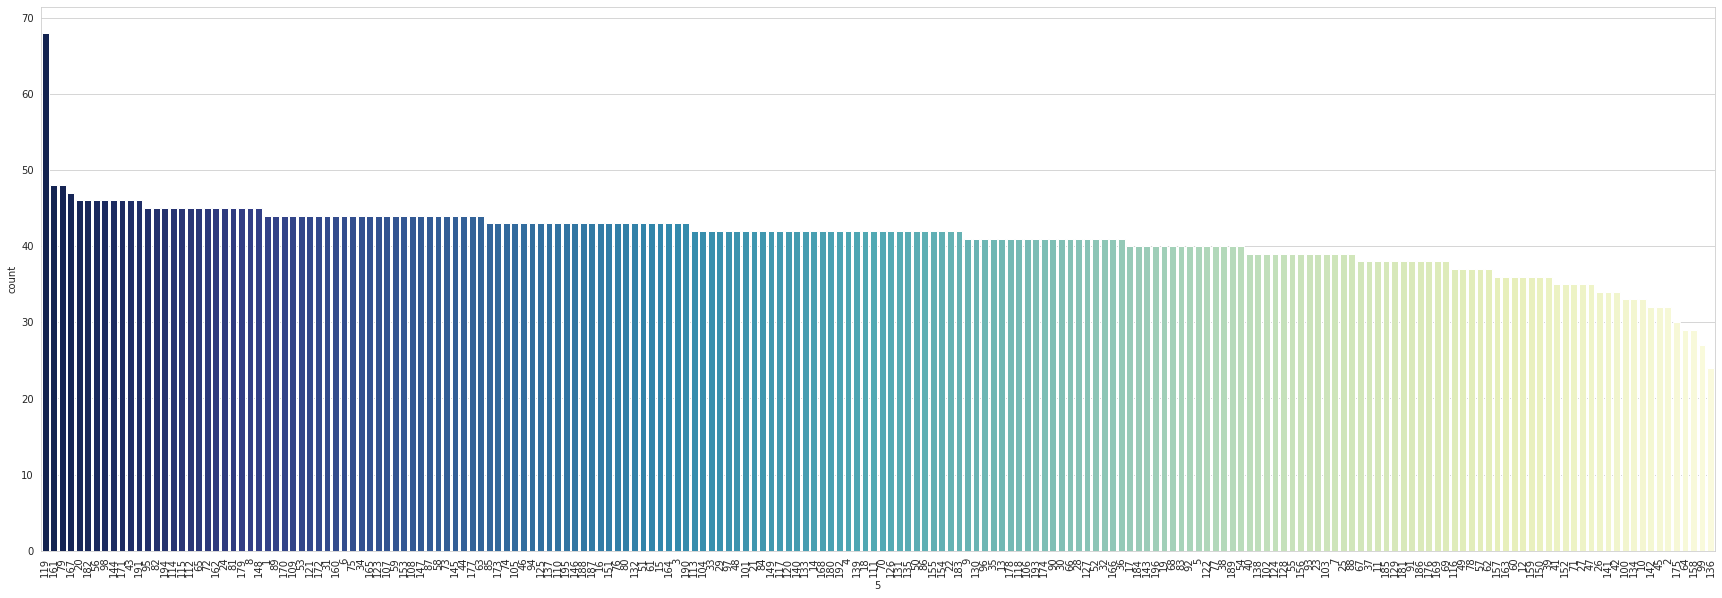

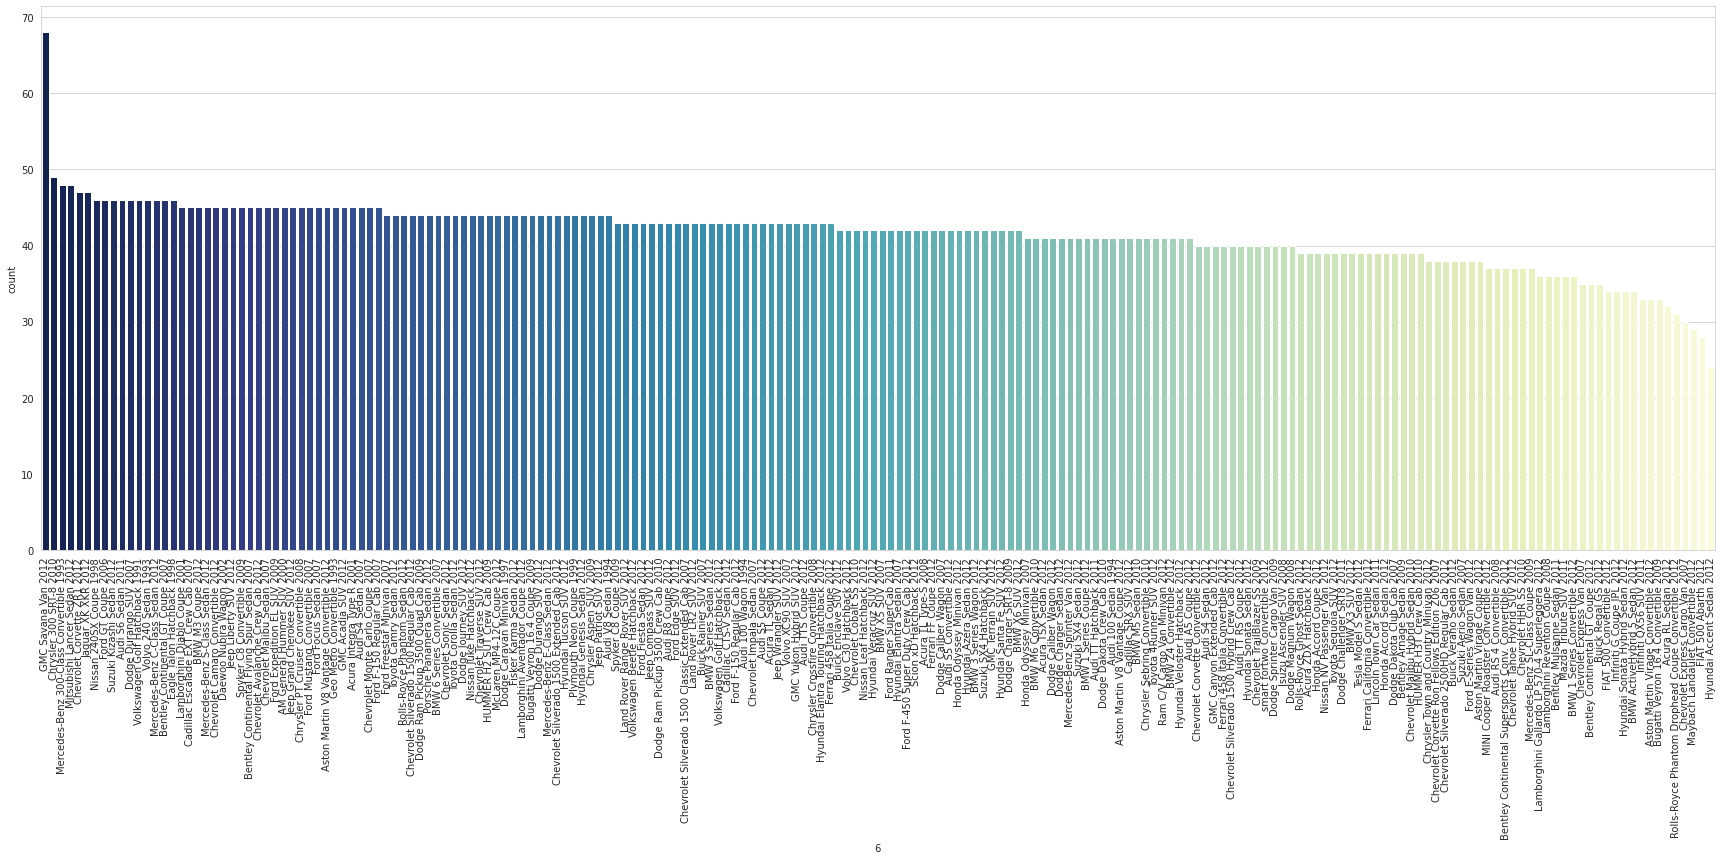

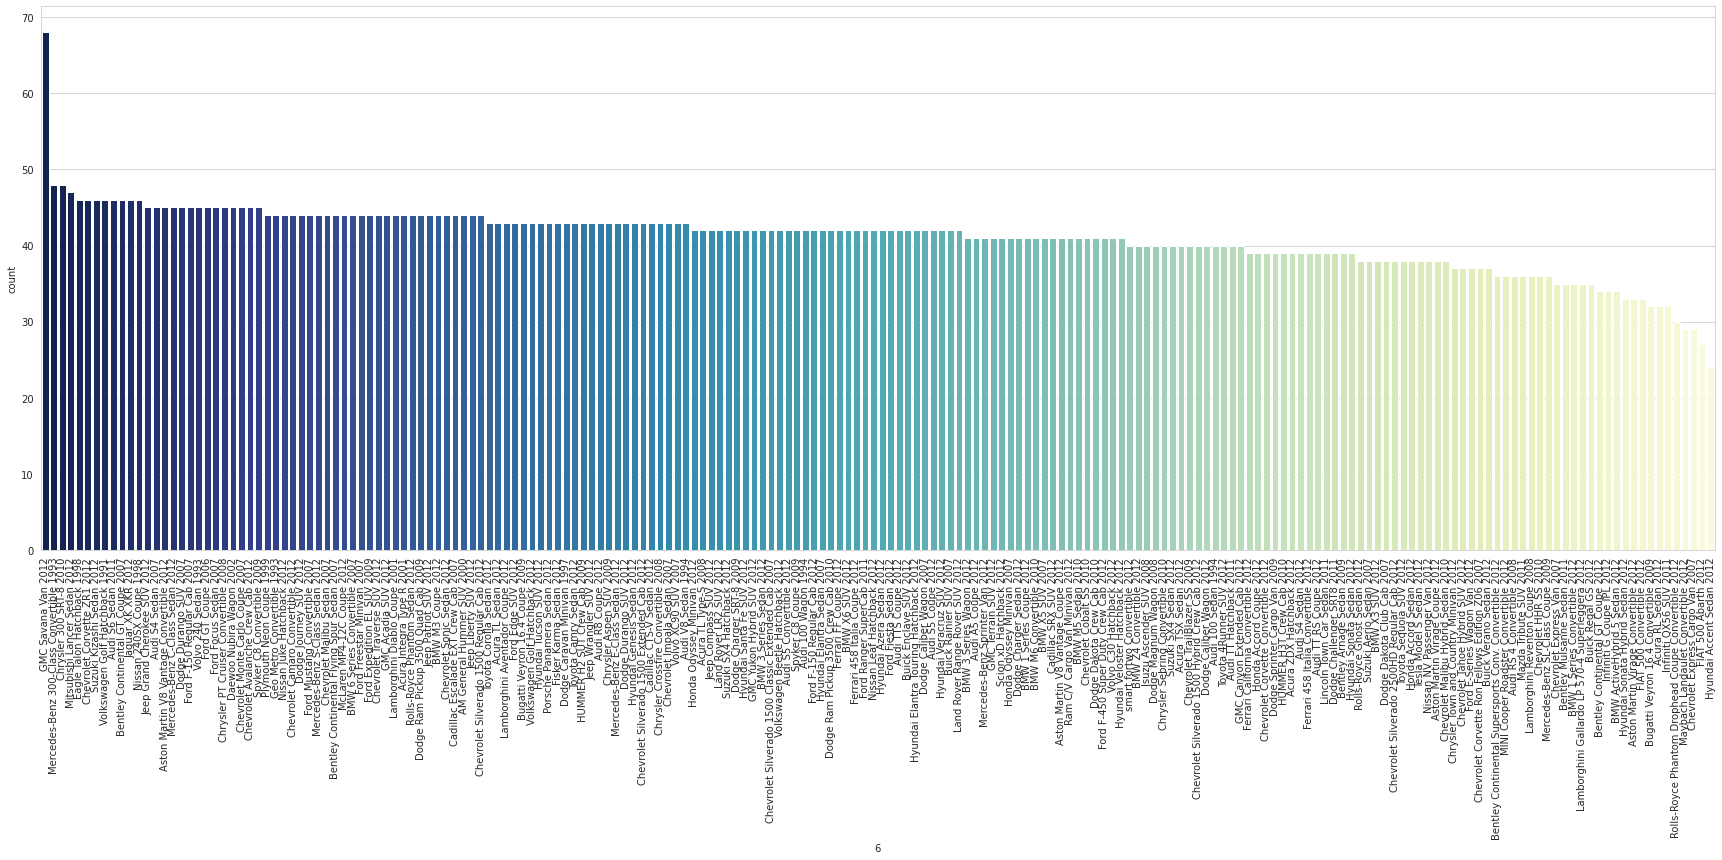

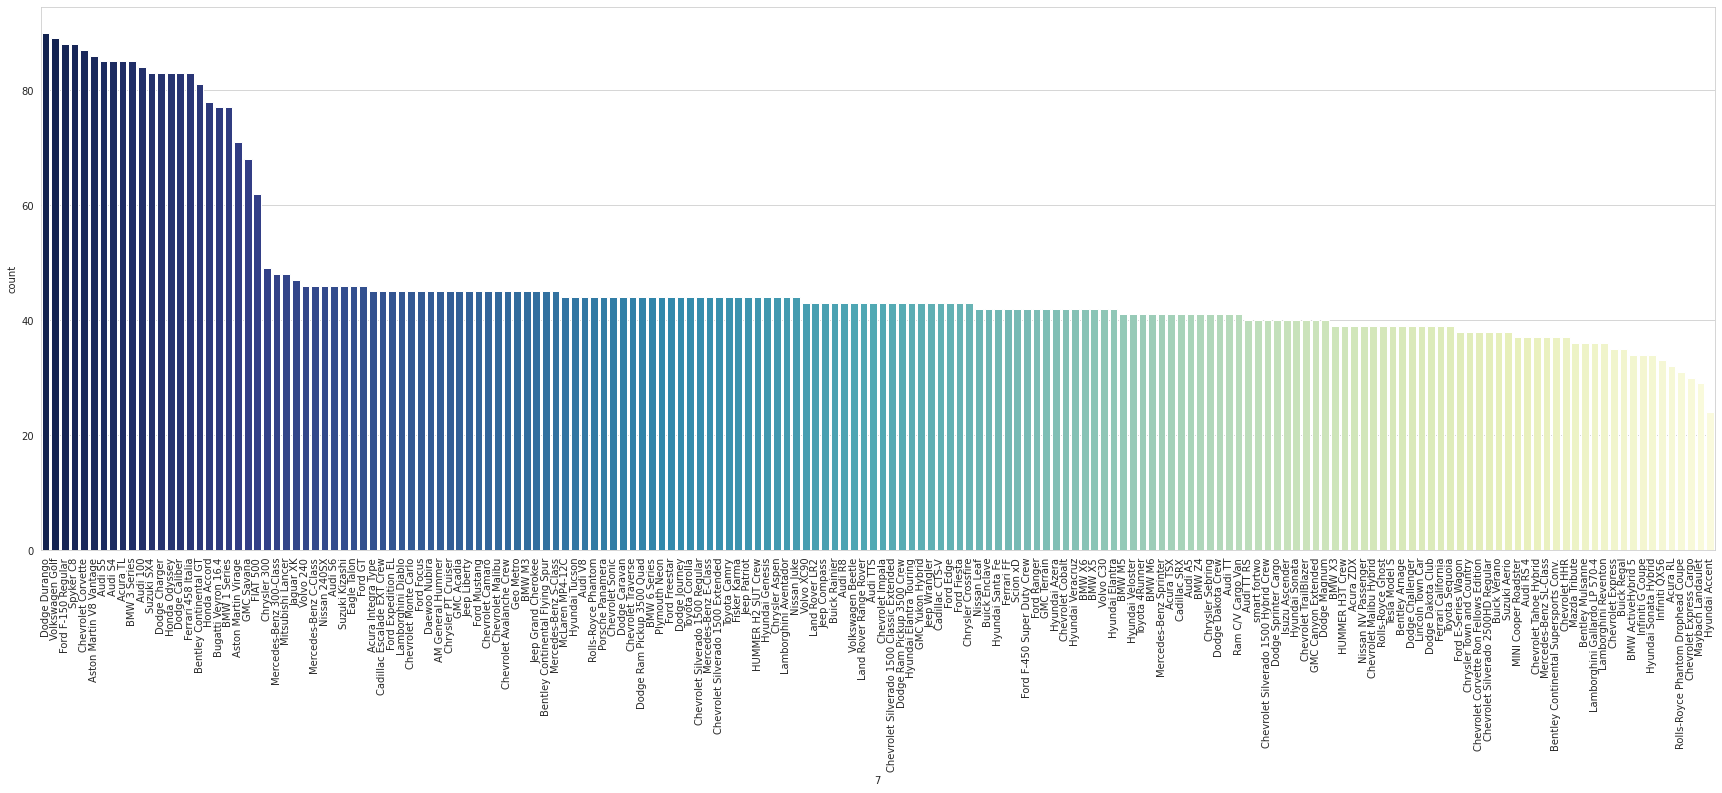

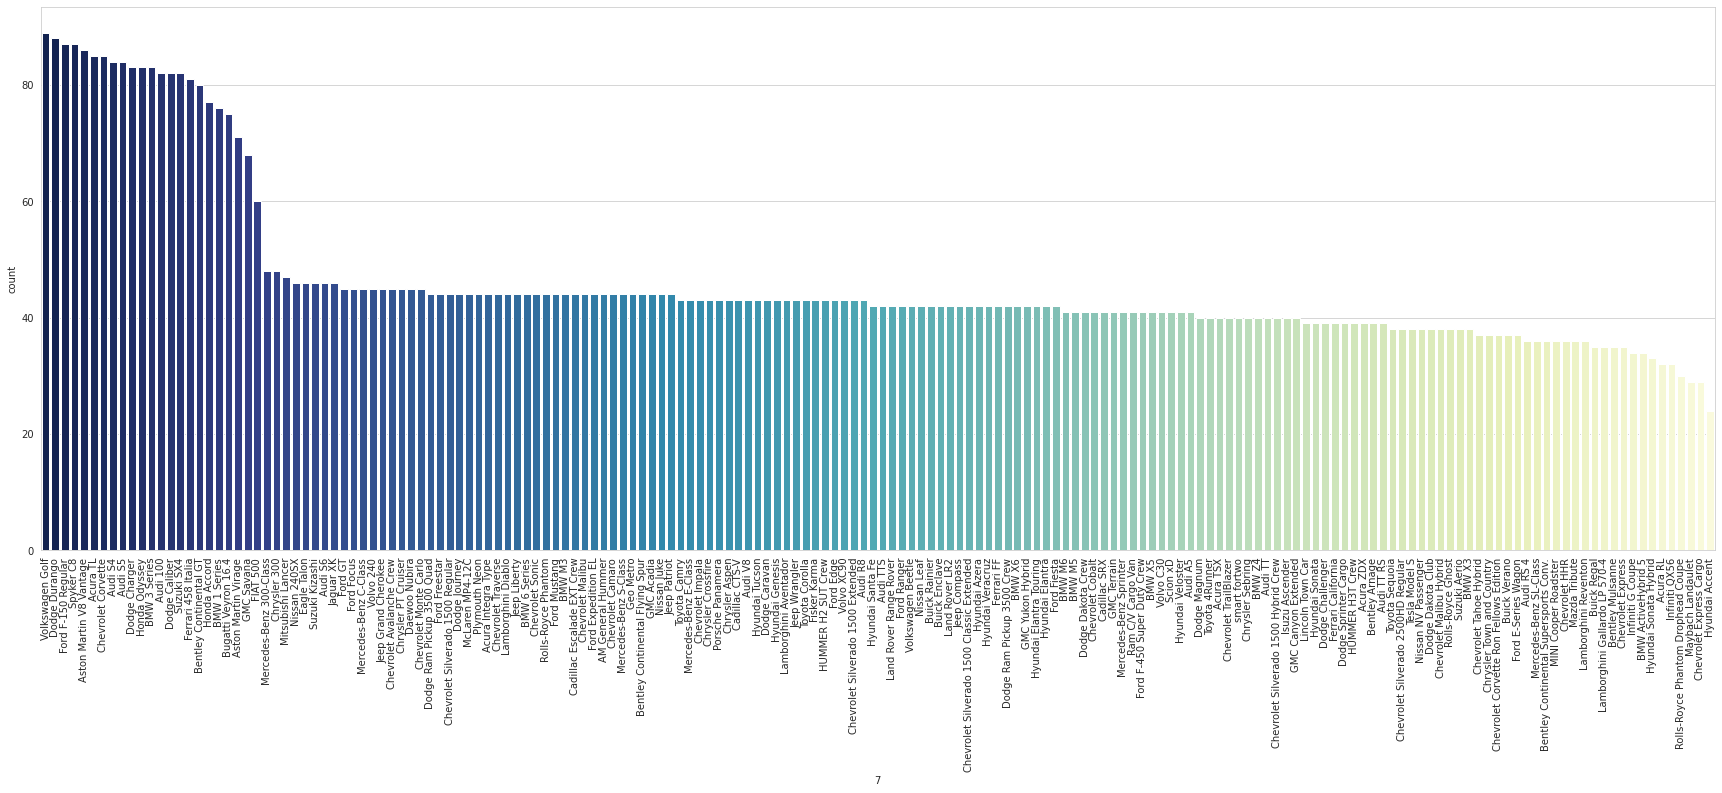

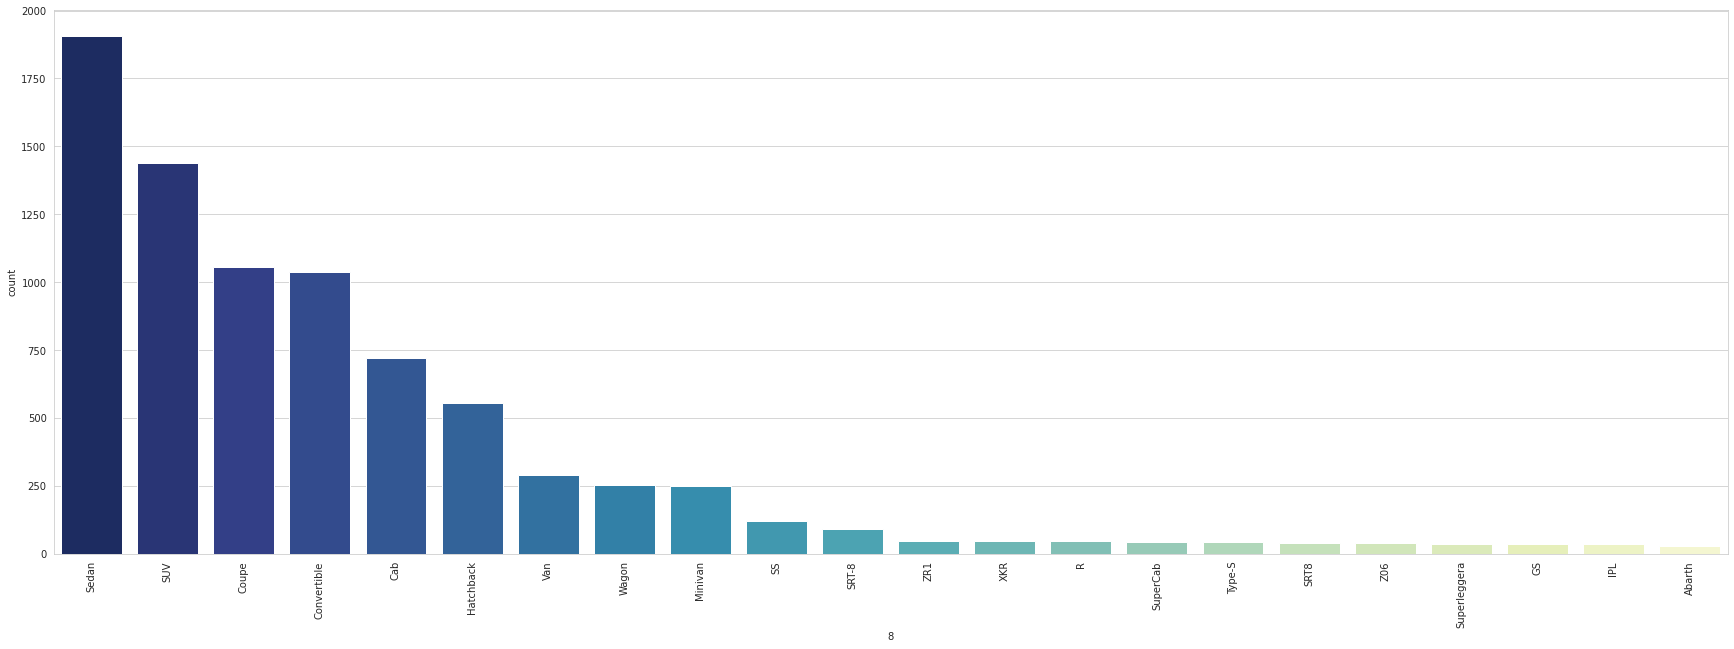

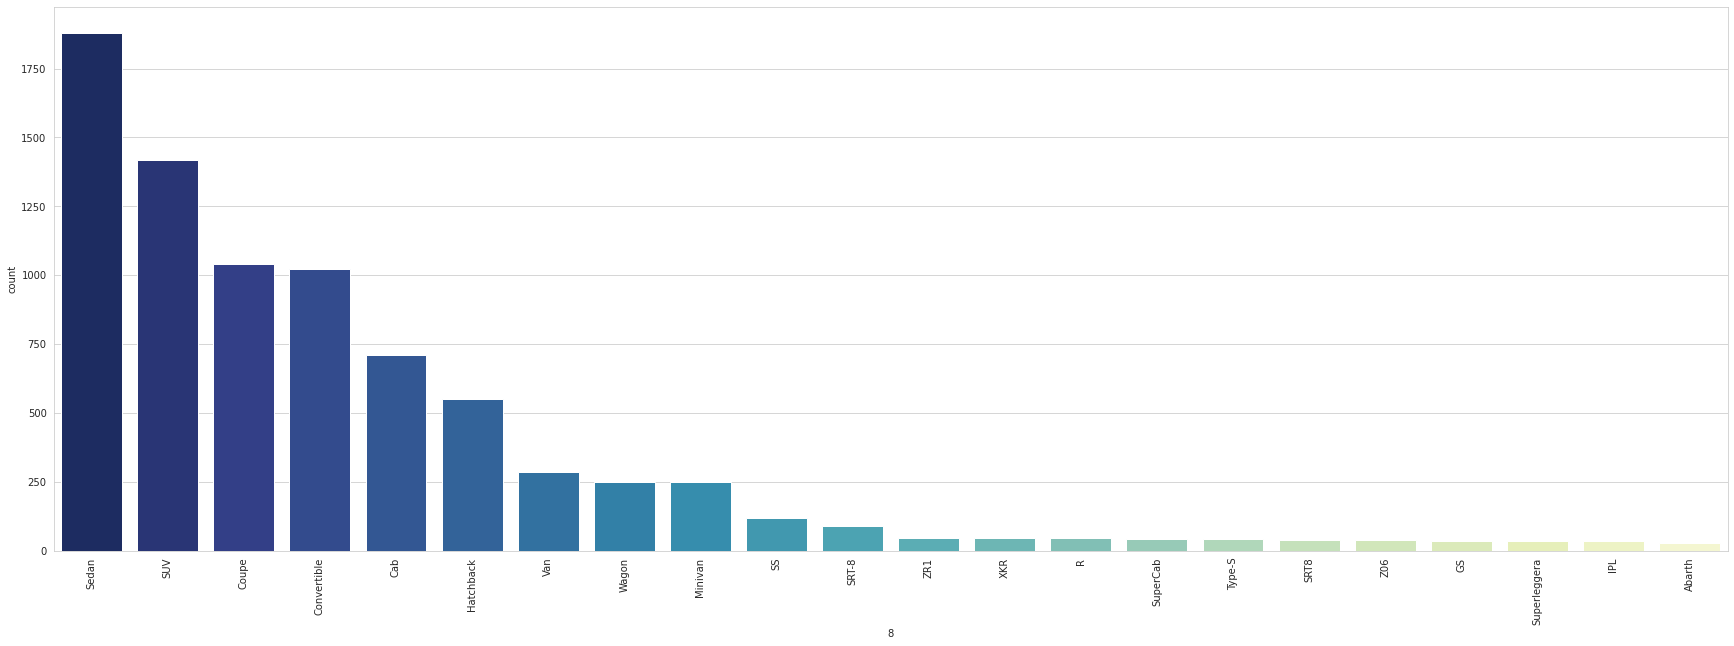

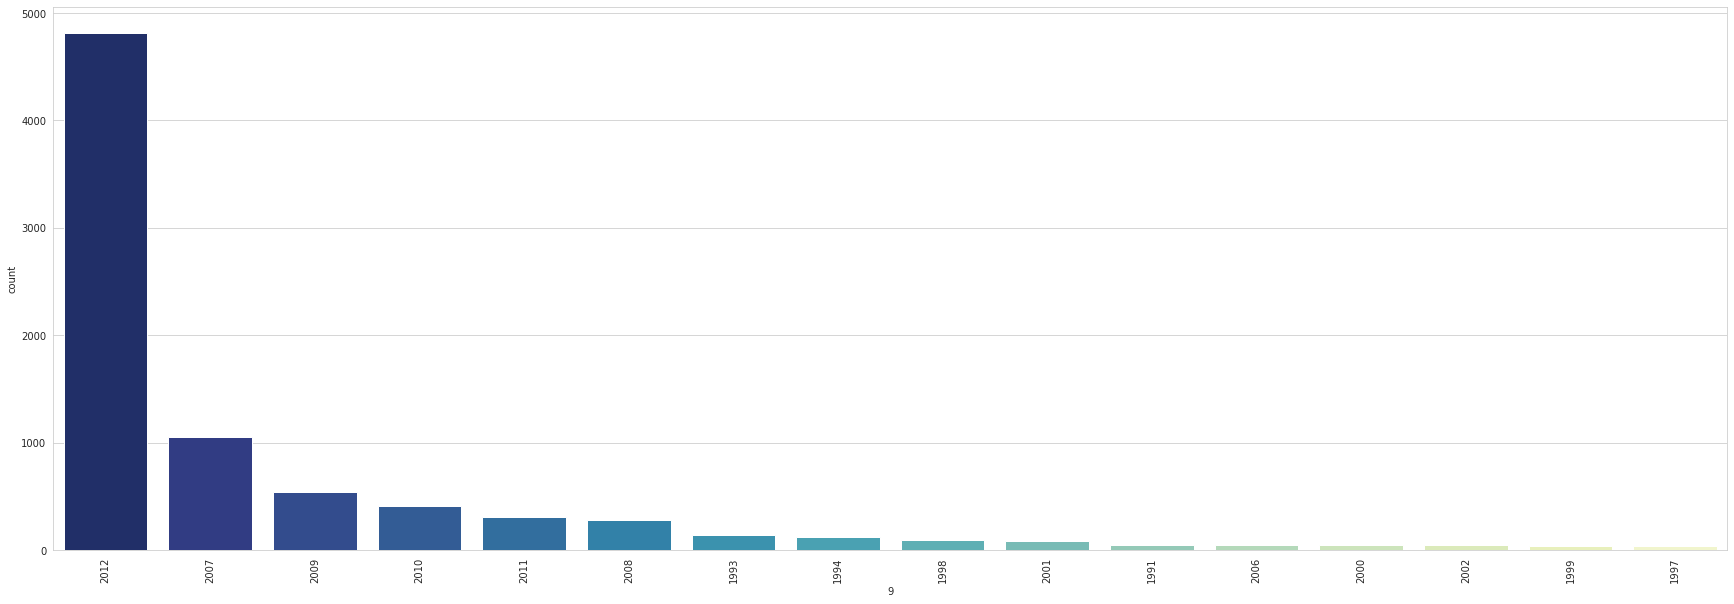

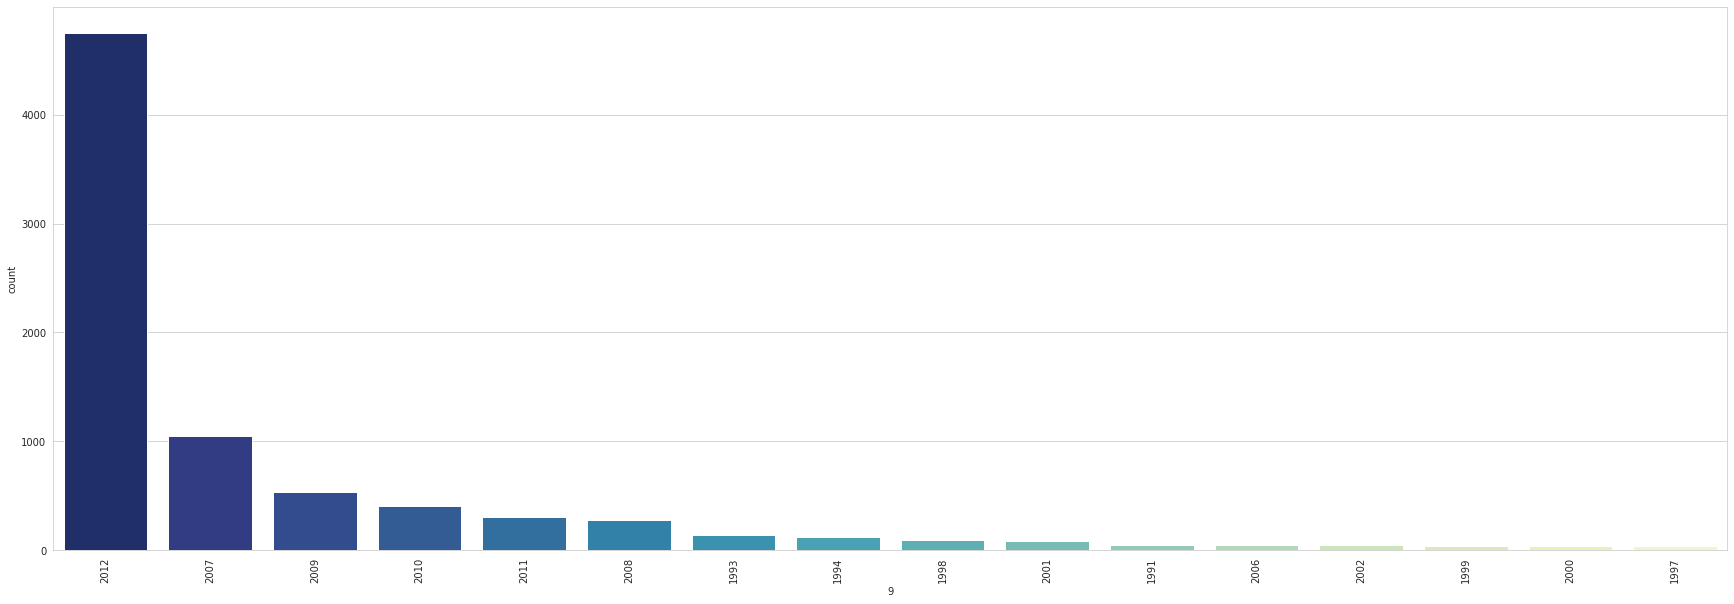

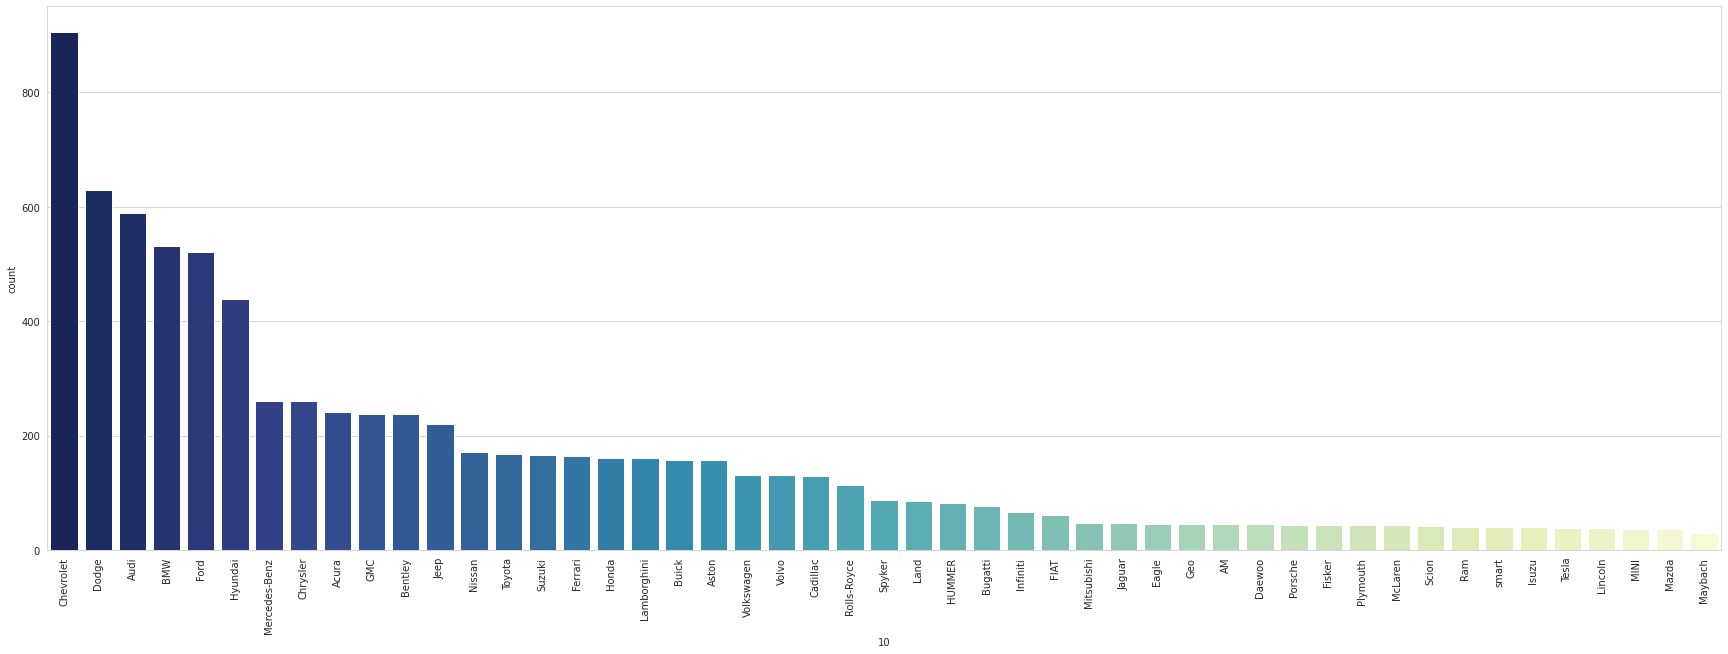

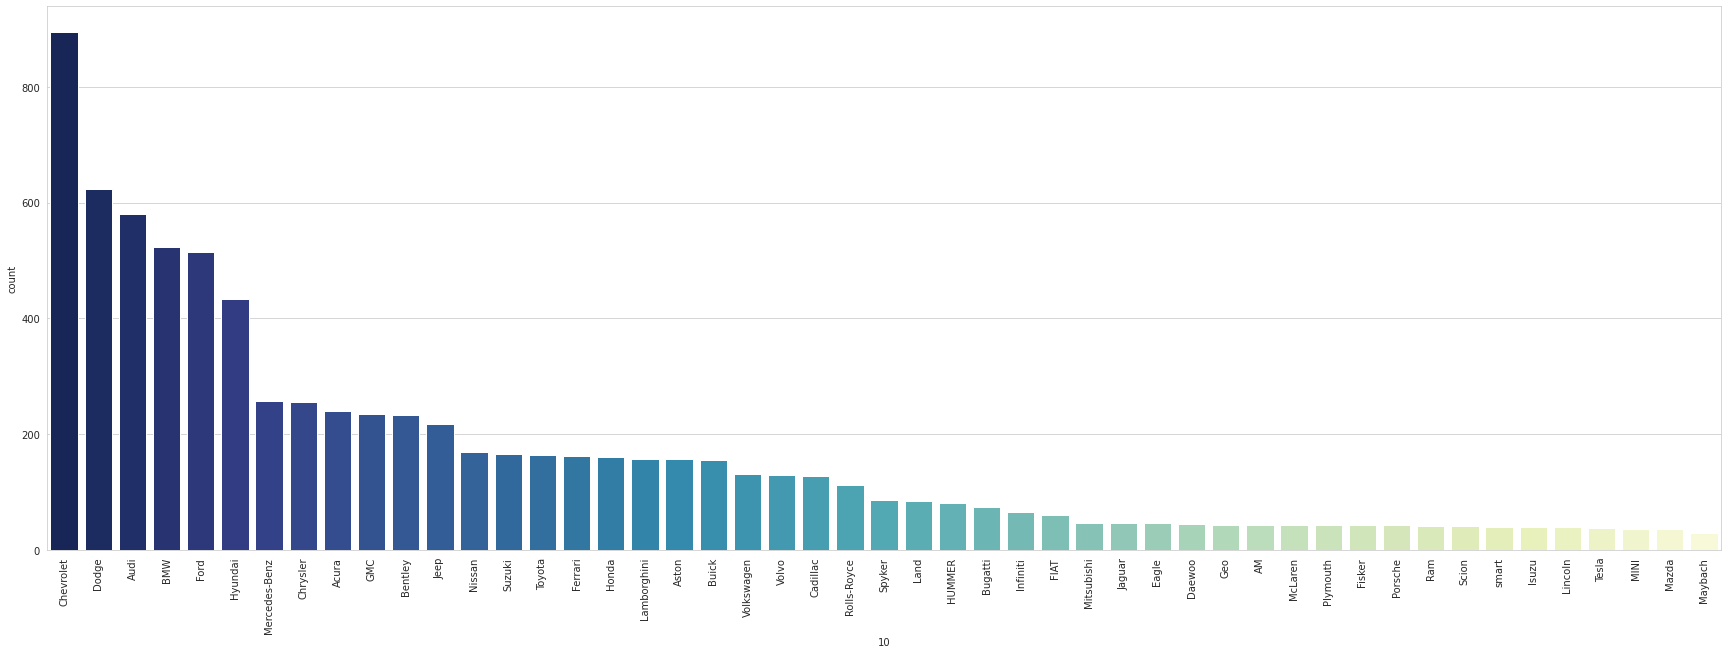

In [29]:
countI = [5,6,7,8,9,10]
for i in countI:
  draw_count_plot(train_data,i)
  draw_count_plot(test_data,i)

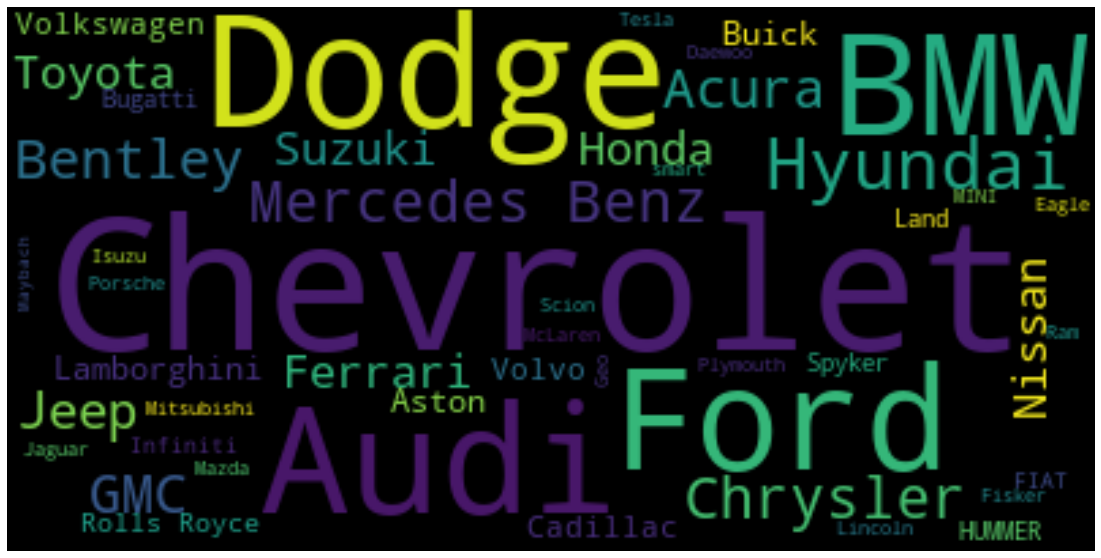

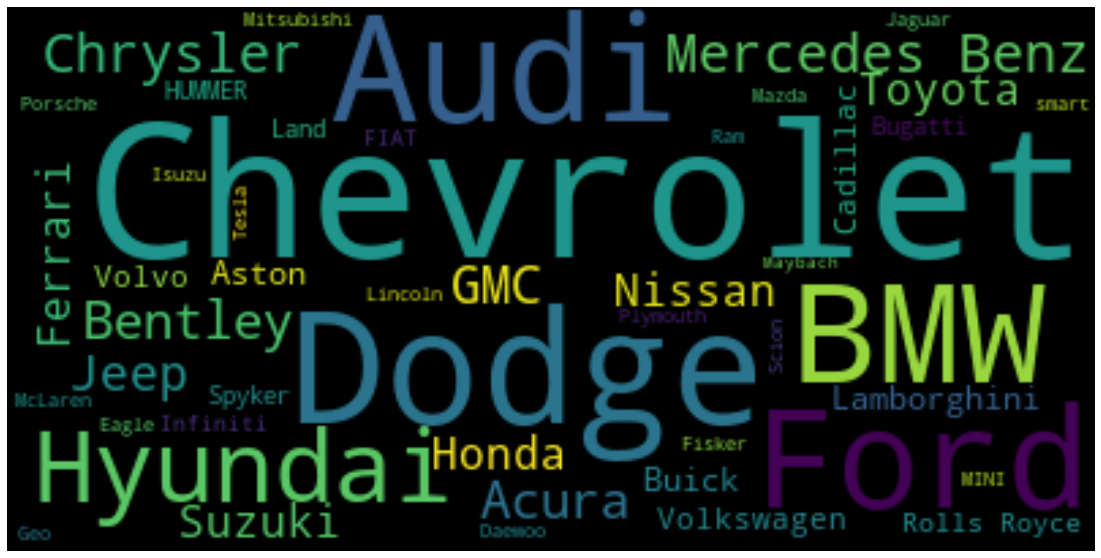

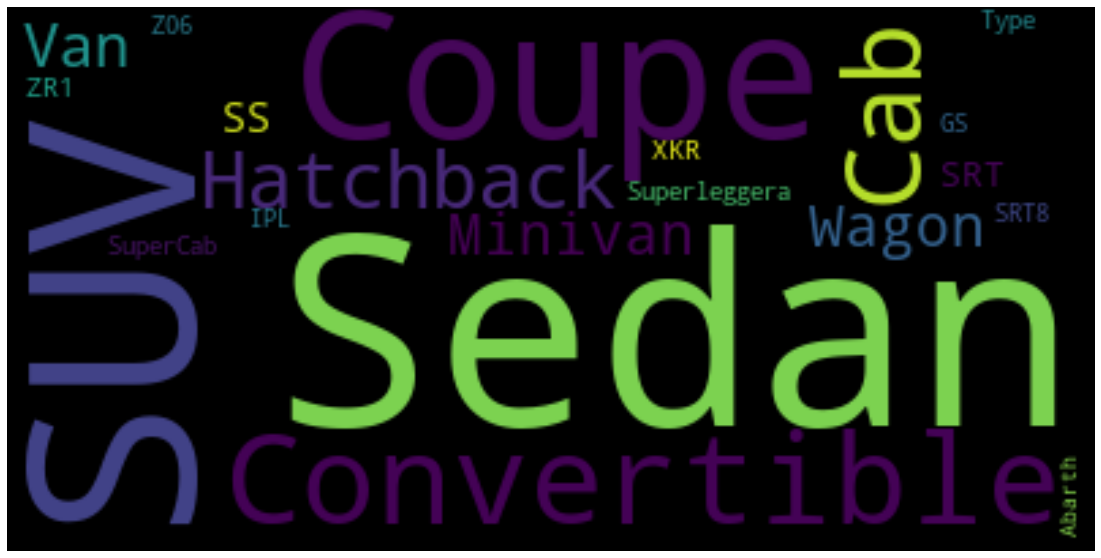

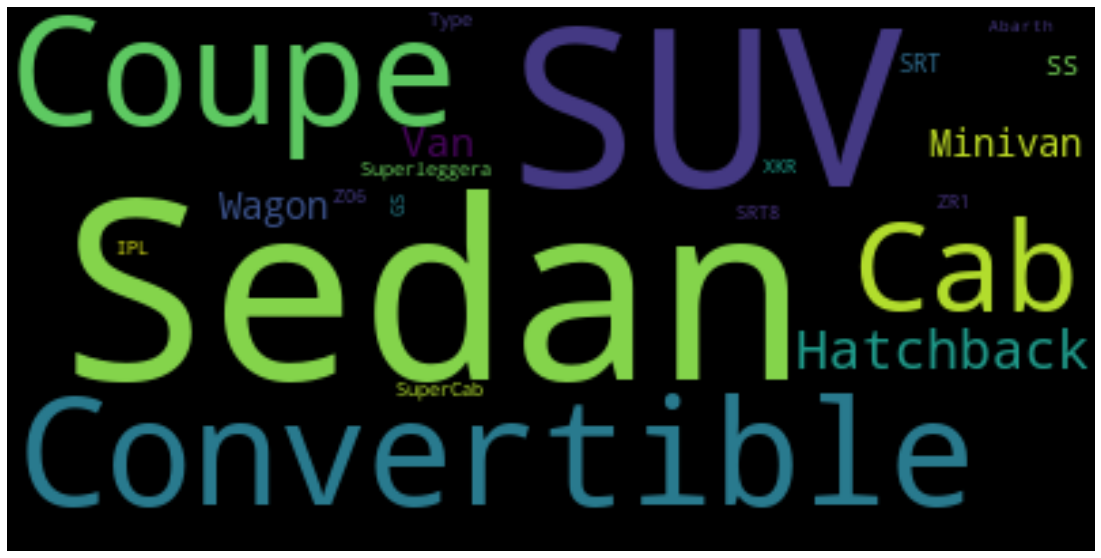

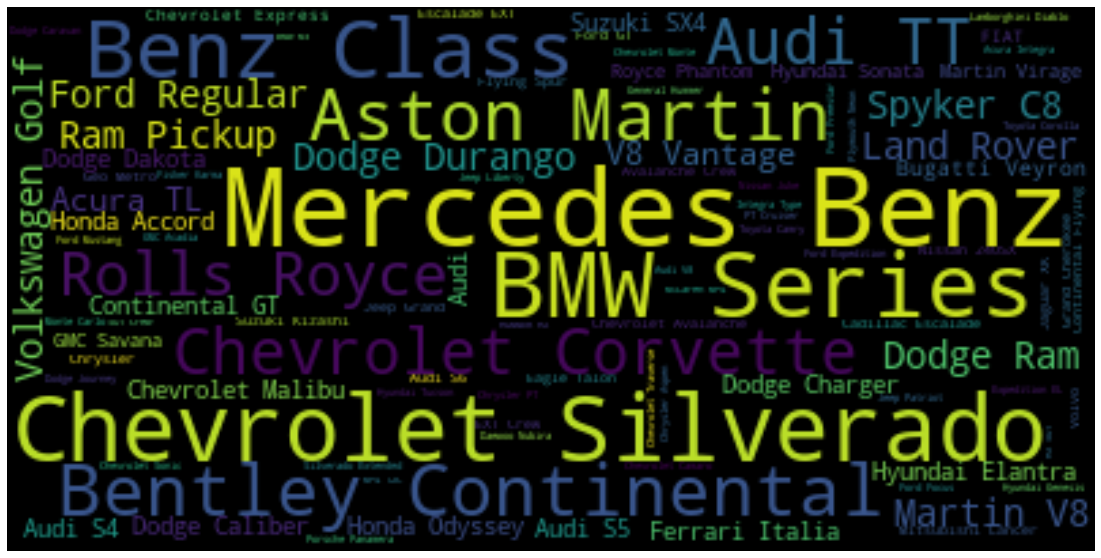

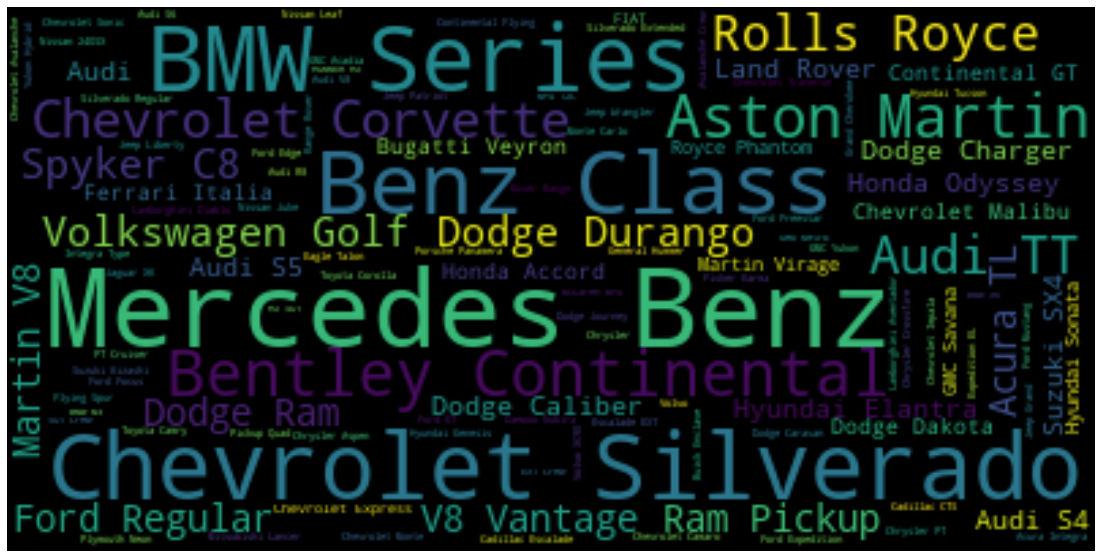

In [28]:
cloudI = [10,8,7]
for i in cloudI:
  draw_word_cloud(train_data[i])
  draw_word_cloud(test_data[i])

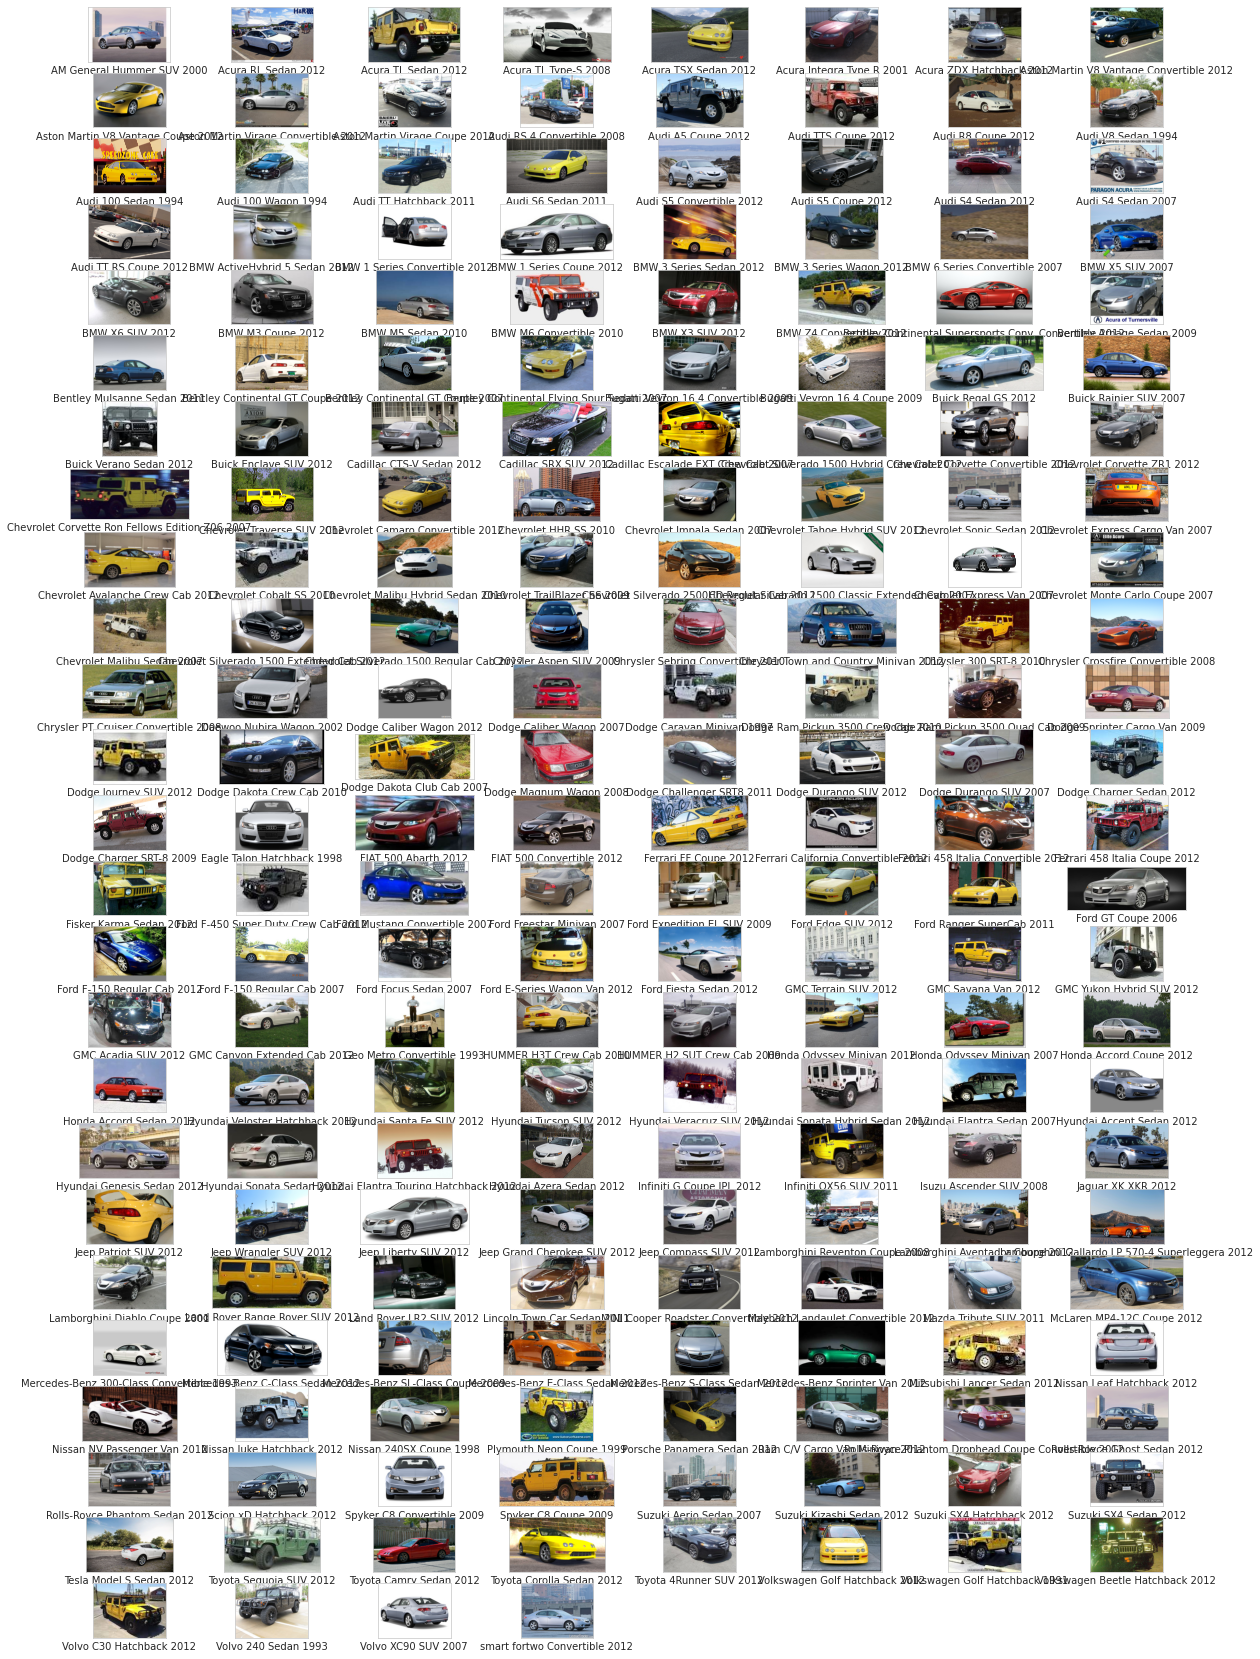

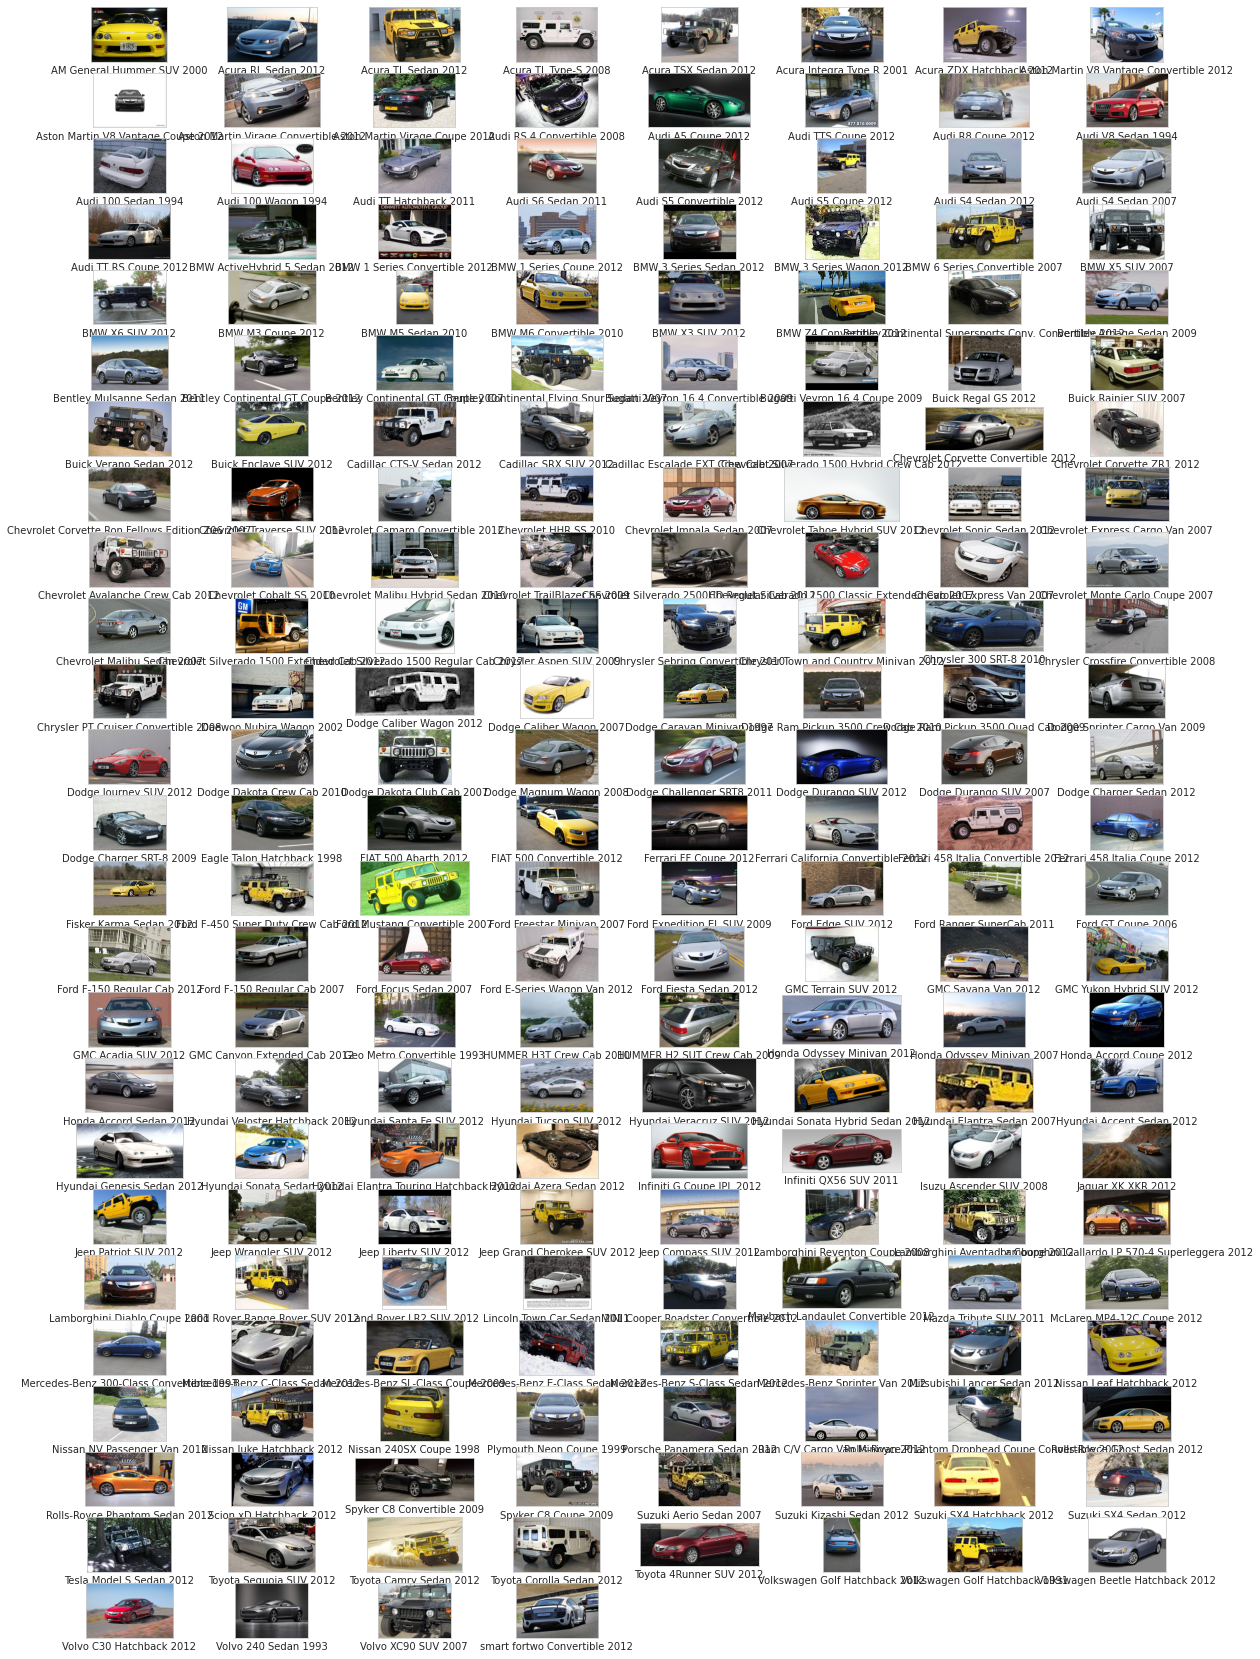

In [39]:
# one image example from each class
draw_image_from_each_class(train_data,data_labels,trainMetaData)
draw_image_from_each_class(test_data,data_labels,testMetaData)